# Vizualizacija podatkov

## Okolje



In [ ]:
!pip install bertopic
!pip install matplotlib --upgrade
!pip install classla
!pip install tweet-preprocessor

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string
import json
import time
import nltk
import classla
import preprocessor as tpre
#nltk.download('stopwords')
#classla.download('sl')
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification, pipeline

from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Setting constants

LOCAL = False

google_data_dir = "/content/drive/MyDrive/Diploma/Data"
local_data_dir = "/data"

root_dir = ""
if LOCAL:
    root_dir = local_data_dir
else:
    root_dir = google_data_dir

In [ ]:
font = {
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

## Funkcije in razredi

In [ ]:
def load_data(file_name):
  
  # Load data
  data = []

  with open(file_name, 'r', encoding='utf8') as sample_data:
    data = json.load(sample_data)

  return data

def load_labelled_tweets(dir, topic_names, shuffle_arrays=True, random_state=77):
  topics = []
  for t in topic_names:
    with open(f'{dir}/labelled_topics/topic_{t}.json', 'r', encoding='utf8') as topic_data:
      data = json.load(topic_data)
      topics.extend(data)
  
  topic_lemmas = []
  topic_labels = []

  for t in topics:
    topic_lemmas.append(t['lemma_text'])
    topic_labels.append(t['topic'])

  topic_labels = [ topic_names.index(x) for x in topic_labels]

  if shuffle_arrays:
    shuffle(topic_lemmas, topic_labels, random_state=random_state)
  return topic_lemmas, topic_labels

def preprocess_tweets(preprocess_pipeline, tweets, tweet_stop_words=[], tweet_upos=[], min_words=4, verbose=False, debug=False):

  stop_words = stopwords.words('slovene')
  stop_words.extend(tweet_stop_words)

  # Remove stopwords
  stop_words = list(set(stop_words))

  data = []
  start_time = 0

  for index, tweet in enumerate(tweets):

    if index%1000 == 0 and verbose:
      # Import time
      print(f'-- Progress: {index}/{len(tweets)}')
      if index >= 1000:
        print(f'-- Time elapsed: {time.time() - start_time}s')
        print(f'-- Tweets preprocessed: {len(data)}')
      start_time = time.time()

    # Take attributes
    tweet_full_text = tweet['full_text']

    # Skip if retweet
    if tweet_full_text.startswith("RT"):
      continue

    tweet_id = tweet['id']
    #tweet_hashtags = tweet['entities']['hashtags']
    #tweet_mentions = tweet['entities']['mentions']
    tweet_hashtags = tweet['hashtags']
    tweet_mentions = tweet['mentions']
    tweet_created_at = tweet['created_at']

    tweet_user_name = tweet['user']['name']
    tweet_user_screen_name = tweet['user']['screen_name']
    tweet_user_description = clean_tweet_text(tweet['user']['description']).lower()
    
    # Remove hashtags, mentions, links, emojis and others
    tweet_full_text = clean_tweet_text(tweet_full_text)

    if debug:
      print(f'Raw text:\n{tweet_full_text}')

    # Preprocess with preprocessing pipeline
    tweet_lemma_text = preprocess_pipeline(tweet_full_text)

    tweet_processed_lemmas = []
    for sentence in tweet_lemma_text.sentences:

      sentence_words = []

      for i, word in enumerate(sentence.words):
 
        # If the tweet is a retweet
        if word.lemma.lower() == 'rt' and i == 0:
          break

        if debug:
          print(f'Lemma: {word.lemma.lower()} -------------- Upos: {word.upos}')

        # Not punctuation and not number + clean stopwords
        if word.upos not in tweet_upos and word.lemma.lower() not in stop_words:
          sentence_words.append(word.lemma.lower())
        elif debug:
          print(f'Discarded word: {word.lemma}')

      tweet_processed_lemmas.extend(sentence_words)
    
    if debug:
      print(f'Preprocessed lemmas:\n{tweet_processed_lemmas}')

    # If less than n words
    if len(tweet_processed_lemmas) > min_words:
      tweet_data = {
          "id": tweet_id,
          "created_at": tweet_created_at,
          "raw_text": tweet_full_text,
          "lemma_text": ' '.join(tweet_processed_lemmas),
          "hashtags": tweet_hashtags,
          "mentions": tweet_mentions,
          "user": {
              "name": tweet_user_name,
              "screen_name": tweet_user_screen_name,
              "description": tweet_user_description
          }
      }

      # Append all the data
      data.append(tweet_data)
    
  return data

def clean_tweet_text(tweet_text):
  tweet_text = tpre.clean(tweet_text)
  tweet_text = re.sub("&gt;|&lt;|&amp;", "", tweet_text)
  tweet_text = remove_emojis(tweet_text)
  return tweet_text

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def overwrite_labelled_topics(file_topic, topic_tweets, data_dir):
    data=[]
    with open(f'{data_dir}/labelled_topics/topic_{file_topic}.json', 'r', encoding='utf8') as topic_data:
      data = json.load(topic_data)
      data.extend(topic_tweets)
    with open(f'{data_dir}/labelled_topics/topic_{file_topic}.json', 'w', encoding='utf8') as topic_data_n:
      json.dump(data, topic_data_n, ensure_ascii=False)

def overwrite_labelled_tweets(topic, tweets, data_dir):
  # Overwrite
  data=[]
  with open(f'{data_dir}/process/tweets_{topic}.json', 'r', encoding='utf8') as topic_data:
    data = json.load(topic_data)
    data.extend(tweets)
  with open(f'{data_dir}/process/tweets_{topic}.json', 'w', encoding='utf8') as topic_data_n:
    json.dump(data, topic_data_n, ensure_ascii=False)


"""
Bertopic model for modeling topics

"""
class BertopicModel:

  def __init__(self, model_name, embed_model, config):
    self.model_name = model_name
    self.embed_model = embed_model
    self.config = config

    # Create the Bertopic model with config
    self.make_model()

  def make_model(self):
    self.umap_model = UMAP(**self.config["umap_conf"])
    self.hdbscan_model = HDBSCAN(**self.config["hdbscan_conf"])
    self.bertopic = BERTopic(embedding_model=self.embed_model, umap_model=self.umap_model, hdbscan_model=self.hdbscan_model, **self.config["bertopic_conf"])

  def load_tweet_data(self, tweet_data):
    doc_tweet_lemmas = [ t['lemma_text'] for t in tweet_data ]
    
    self.data = {}
    self.data["tweets"] =  tweet_data
    self.data["docs"] = doc_tweet_lemmas

  def load_topic_data(self, topic_docs, topic_labels):
    if not hasattr(self, 'data'):
      self.data = {}
      
    self.data["docs"] = topic_docs
    self.data["labels"] = topic_labels

  def train_model(self, only_fit):
    data_keys = self.data.keys()

    if "docs" in data_keys and not only_fit:
      topics, probs = self.bertopic.fit_transform(self.data["docs"])
      self.result = {}
      self.result["topic_ids"] = topics
      self.result["topic_probs"] = probs
    elif "docs" in data_keys and "labels" in data_keys and only_fit:
      self.bertopic = self.bertopic.fit(self.data["docs"], y=self.data["labels"])
    else:
      print("Error: Missing data!")
  
  def predict(self):
    data_keys = self.data.keys()

    if "docs" in data_keys:
      topics, probs = self.bertopic.transform(self.data["docs"])
      self.result = {}
      self.result["topic_ids"] = topics
      self.result["topic_probs"] = probs

  def reduce(self, nr):
    if hasattr(self, 'data') and hasattr(self, 'result'):
      topics, probs = self.bertopic.reduce_topics(self.data["docs"], self.data["labels"], nr_topics=nr)
      self.result["topic_ids"] = topics
      self.result["topic_probs"] = probs

  def merge_topics(self, indexes):
    if hasattr(self, 'data'):
      self.bertopic.merge_topics(self.data["docs"], self.data["labels"], indexes)

  def tweets_from_topic(self, ntopic):
    if self.result:
      tw = []

      for i, x in enumerate(self.result.topic_ids):
        if x == ntopic:
          tw.append(self.data["docs"][i])

      return tw
    else:
      print("Error: Missing data!")
      return []

  def collect_topic_indices(self, ntopic, tweet_prob=0.5):
    if hasattr(self, 'result'):

      tweet_ids = []
      for i, x in enumerate(self.result["topic_ids"]):

        # Check if topic id and probability higher
        if ntopic == x and self.result["topic_probs"][i] > tweet_prob:
          tweet_ids.append(i)

      return tweet_ids
    else:
      print("Error: Missing data!")
      return []

  def find_politic_topics(self, keywords, topn=3, sim_threshold=0.5, tweet_prob=0.5, include_prob=False):
    if hasattr(self, 'bertopic'):
      indices = set()

      # Find relating topics
      for keyword in keywords:
        sim_ids, sim_probs = self.bertopic.find_topics(keyword, top_n=topn)

        # Filter based on similarity
        sim_topics = [ sim_ids[i] for i, x in enumerate(sim_probs) if x > sim_threshold ]

        if len(sim_topics) > 0:
          for topic in sim_topics:
            indices.update(self.collect_topic_indices(topic, tweet_prob=tweet_prob))
      
      tweet_docs = []
      for i in indices:
        tdoc = self.data["tweets"][i]
        if include_prob:
          tdoc["topic_probability"] = self.result["topic_probs"][i]

        tweet_docs.append(tdoc)

      return tweet_docs
    else:
      print("Error: Missing data!")
      return []

  def visualize(self, t='distance_map'):
    if hasattr(self, 'bertopic'):
      #return self.bertopic.visualize_topics()
      if t == 'barchart':
        return self.bertopic.visualize_barchart()
      elif t == 'hierarchy':
        return self.bertopic.visualize_hierarchy()
      elif t == 'heatmap':
        return self.bertopic.visualize_heatmap()
      elif t == 'term_rank':
        return self.bertopic.visualize_term_rank()
      else:
        return self.bertopic.visualize_topics()
      #elif t == 'documents':
      #  self.bertopic.visualize_documents()
    else:
      print("Error: Model not yet initiated!")

  def save_model(self, model_dir):
    self.bertopic.save(str(model_dir + self.model_name))
  
  def load_model(self, model_dir):
    self.bertopic.load(str(model_dir + self.model_name), embedding_model=self.embed_model)

"""

Tweetiment Model

"""

class TweetimentModel:
  def __init__(self, name, model, tokenizer, topic_bias, party_bias):
    self.model_name = name

    self.topic_bias = topic_bias
    self.party_bias = party_bias

    self.labels = ["levo", "desno", "nevtralno"]
    
    self.tokenizer = tokenizer
    self.model = model

    # Create the pipeline
    self.make_model()
  
  def make_model(self):
    self.tweetiment = pipeline("sentiment-analysis", model=self.model, tokenizer=self.tokenizer)

  def predict_text(self, txt):
    if hasattr(self, 'tweetiment'):
      return self.tweetiment(txt)

  def classify(self, bias_party, bias_topic):

    if bias_party is None and bias_topic is None:
      return self.labels[2]
    elif bias_party is None:
      return bias_topic
    elif bias_topic is None:
      return bias_party
    
    return bias_topic

  def calculate_biases(self, tweet, explain=False):
    if tweet['raw_text']:
      prediction = self.predict_text(tweet['raw_text'])[0]

      bias_party, party = self.bias_sentiment_party(prediction, tweet)
      #bias_user = self.bias_user(prediction)
      bias_topic, topic = self.bias_sentiment_topic(prediction, tweet)

      if explain:
        explanation = self.make_explanation(prediction['label'], bias_party, party, bias_topic, topic)
      
      label = self.classify(bias_party, bias_topic)

      return {
          'label': label,
          'sentiment': prediction['label'].lower(),
          'sentiment_score': prediction['score'],
          'topic_bias': bias_topic,
          'topic_mentioned': topic,
          'topic_score': tweet['topic_probability'],
          'party_bias': bias_party,
          'party_mentioned': party,
      }
    return None

  # Bias based on negativity/positivity towards a party mentioned in a tweet
  def bias_sentiment_party(self, prediction, tweet, single=True):
    """
    Args:
      single (bool): Detect only a single party in tweet
      
    Returns:
      bias
    """
    bias = None
    party_detected = None
    parties_mentioned = 0

    for party in self.party_bias:
      
      for mention in tweet['mentions']:
        # Check for mentions or in lemma text
        if mention in party['clani'] or party['kratica_stranke'].lower() in tweet['lemma_text'].split(" "):
          parties_mentioned = parties_mentioned+1
          if parties_mentioned == 1:
            party_detected = party
          break

    if single and parties_mentioned == 1 and party_detected is not None:

      # If text is neutral
      if prediction['label'] == "Neutral":
        bias = self.labels[2]
      # Supports the party
      elif prediction['label'] == "Positive":
        bias = self.labels[party_detected['usmerjenost']]
      # Opposes the party
      elif prediction['label'] == "Negative":
        bias = self.labels[int(not party_detected['usmerjenost'])]

      return bias, party_detected['kratica_stranke']

    # If no parties are mentioned in a tweet
    return None, None
  
  # Bias based on negativity/positivity towards a certain topic of the tweet
  def bias_sentiment_topic(self, prediction, tweet):
    """
    Args:

    Returns:
      bias
    """
    bias = None
    topic_detected = None

    for topic in self.topic_bias:
      if tweet['topic'] == topic and prediction['label'] != 'Neutral':
        
        bias = self.labels[self.topic_bias[topic][prediction['label'].lower()]]
        topic_detected = topic
        break

    return bias, topic_detected
  
  # User a known member of a party?
  def is_user_in_party(self):
    """
    Args:

    Returns:
      bias
    """
    return
  
  # Bias based on the user profile
  def bias_user(self, prediction, tweet):
    """
    Args:
      only_desc (bool): Analyze description on user profile only

    Returns:
      bias
    """
    return

  def make_explanation(self, sentiment, bias_party, party, bias_topic, topic):
    # TODO
    return

"""

Politic bias model

"""

class PoliticBiasModel:
  def __init__(self,
                name,
                working_dir,
                preprocess_pipeline,
                topic_model,
                sentiment_model,
                config
               ):

    self.name = name
    self.working_dir = working_dir
    self.preprocess_pipeline = preprocess_pipeline
    self.config = config

    # Make models
    self.make_models(topic_model, sentiment_model)

  def make_models(self, topic_model, sentiment_model):

    # Create Bertopic SL
    self.bertopic_SL = BertopicModel("Bertopic_SL", embed_model=topic_model, config=self.config['bertopic_SL_config'])

    # Create Tweetiment
    self.tweetiment = TweetimentModel("Tweetiment", model=sentiment_model['model'], tokenizer=sentiment_model['tokenizer'], topic_bias=self.config['tweetiment_config']['topic_bias'], party_bias=self.config['tweetiment_config']['party_bias'])

  def train_models(self):
    topic_names = [x for x in self.config['topic_info']]

    # Loading labelled tweets to train
    X_train, y_train = load_labelled_tweets(self.working_dir, topic_names, shuffle_arrays=self.config['bertopic_SL_config']['shuffle_arrays'], random_state=self.config['bertopic_SL_config']['random_state'])

    # Load training data
    self.bertopic_SL.load_topic_data(X_train, y_train)

    # Train the model
    self.bertopic_SL.train_model(only_fit=True)

  def optimize_models(self, topn=3, n_sim_subtopics=3):
    sim_topics = similar_topics(self.bertopic_SL, self.config['topic_info'], topn=topn, n_sim_subtopics=n_sim_subtopics)

    all_labels = [ x for x in self.bertopic_SL.bertopic.get_topics()]
    to_elim = []
    merging = False

    for st in sim_topics:
      lbl = sim_topics[st]
      lbl = [ t for t,p in lbl if p > 0.9]

      if len(lbl) > 1:
        to_elim.append(lbl)
        all_labels = [ x for x in all_labels if x not in lbl]
        merging = True

    #for e in to_elim:
      #all_labels.append(e)
    print(to_elim)
    if merging:
      self.bertopic_SL.merge_topics(to_elim)


  def bias_pipeline(self, tweets, topn=3, n_sim_subtopics=4, do_preprocess=True):
    """
    ## Automated Slovenian Political bias pipeline
    """

    # Preprocess instances
    if do_preprocess:
      p_tweets = preprocess_tweets(self.preprocess_pipeline, tweets, self.config['preprocess_config']['tweet_stop_words'], self.config['preprocess_config']['tweet_stop_words'], verbose=self.config['verbose'], debug=self.config['debug'])
      # Load the tweet data
      self.bertopic_SL.load_tweet_data(p_tweets)

      # Predict the instances
      self.bertopic_SL.predict()

      # Topic unlabelled tweets
      #unlabelled_tweets = [ tweets[i] for i, tx in enumerate(self.bertopic_SL.result['topic_ids']) if tx == -1]

      # Topic labelled tweets
      labelled_tweets = label_politic_tweets(self.bertopic_SL, self.config['topic_info'], self.working_dir, topn=topn, n_sim_subtopics=n_sim_subtopics, save_tweets=True, verbose=self.config['verbose'])

      # Make bias predictions for labelled tweets
    else:
      labelled_tweets = tweets

    bias_predictions = []
    for t in labelled_tweets:
      bias_predictions.append(self.tweetiment.calculate_biases(t))

    predictions = []
    for twt in tweets:
      id = twt['id']
      found = False

      for ix, lbt in enumerate(labelled_tweets):
        if lbt['id'] == id:
          predictions.append(bias_predictions[ix])
          found = True
          break
      
      if not found:
        predictions.append(None)

    return labelled_tweets, predictions

def label_politic_tweets(model : BertopicModel, topic_info, data_dir, topn=3, n_sim_subtopics=4, save_tweets=False, verbose=True):

  if verbose:
    print(f'-- Collected batch topic distribution summary:')

  sim_topics = similar_topics(model, topic_info, topn=topn, n_sim_subtopics=n_sim_subtopics)

  tweets = model.data['tweets']
  labels = model.result['topic_ids']
  probs = model.result['topic_probs']

  ids = set()

  for i in range(len(tweets)):
    tweet = tweets[i]
    label = labels[i]
    prob = probs[i]

    if tweet['id'] in ids:
      continue
    else:
      ids.add(tweet['id'])

    most_likely_topic = None
    most_likely_prob = 0

    for st in sim_topics:
      for sbt, prob in sim_topics[st]:
        if sbt == label and prob > most_likely_prob:
          most_likely_topic = st
          most_likely_prob = prob


    if most_likely_topic is not None and topic_info[most_likely_topic]['strict']:
      kw = []
      kw.extend(topic_info[most_likely_topic]['keywords'])
      kw.extend(topic_info[most_likely_topic]['search_term'])

      founds = False
      for key in kw:
        if key in tweet['lemma_text']:
          tweet['topic'] = most_likely_topic
          tweet['topic_probability'] = prob
          founds = True
          break
      
      if not founds:
        tweet['topic'] = None
        tweet['topic_probability'] = 0
    else:
      tweet['topic'] = most_likely_topic
      tweet['topic_probability'] = prob
  
  if save_tweets:
    for tp in topic_info:
      t = list(filter(lambda x: x['topic'] == tp, tweets))
      if verbose:
        print(f'-- {tp} : {len(t)}')
      overwrite_labelled_topics(tp, t, data_dir)

  return model.data['tweets']

def similar_topics(model : BertopicModel, topic_info, topn=3, n_sim_subtopics=3) -> dict:
    
  sim_topics = {}

  for topic in topic_info:
    tt = topic_info[topic]

    tpcs1 = {}
    for keyword in tt['search_term']:
      sims = model.bertopic.find_topics(keyword, top_n=topn)

      sims = tuple(zip(sims[0], sims[1]))

      tpcs2 = dict((x, y) for x, y in sims)

      tpcs1 = {
        key: tpcs1.get(key, 0) + tpcs2.get(key, 0) for key in set(tpcs1) | set(tpcs2)
      }
    
    # Normalize
    mv = max(tpcs1.values())
    for kj in tpcs1:
      tpcs1[kj] = float(tpcs1[kj] / mv)
      
    subtopics = []
    for i in range(n_sim_subtopics):
      if tpcs1:
        k1 = max(tpcs1, key=tpcs1.get)
        if k1 != -1:
          subtopics.append((k1, tpcs1[k1]))
        tpcs1.pop(k1)
    
    sim_topics[topic] = subtopics
  
  return sim_topics

## Vizualizacija podatkovne množice

In [ ]:
# Configurations

YEAR = 2021

BATCHES = (1,10)

EPOCHES = [7, 9, 13, 21]

In [ ]:
# Collect data

viz_data = []

for e in EPOCHES:

  e_data = {}
  e_data['e_len'] = 0
  e_data['e_words_len'] = 0

  words = set()
  #words_str = ""

  for i in range(1, 11):
    raw_stpt_data = load_data(f'{root_dir}/stpt/{YEAR}-{e}/{YEAR}_{e}_{i}.json')
    e_data['e_len'] = e_data['e_len'] + len(raw_stpt_data)

    for t in raw_stpt_data:
      for w in t['lemma_text'].split(" "):
        words.add(w)
      
      #words_str = words_str+ " " +(t['lemma_text'])
    
    #e_data['e_words'] = words_str
    e_data['e_words_len'] = len(words)


  viz_data.append(e_data)


In [ ]:
# Visualize data

colors = ['red', 'lime']
labels = ['Število tvitov', 'Število unikatnih besed']

## Vizualizacija rezultatov

In [ ]:
names = ['splav', 'lgbtq', 'begunci', 'religija', 'desno', 'levo']

viz_data = []

for i, n in enumerate(names):
  raw_t_data = load_data(f'{root_dir}/process/tweets_{n}.json')
  viz_data.append(len(raw_t_data))


print(viz_data)


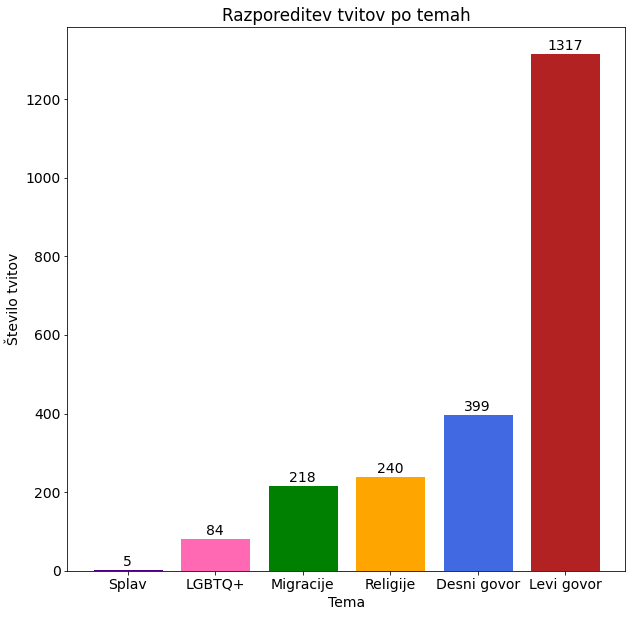

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

nms = ['Splav', 'LGBTQ+', 'Migracije', 'Religije', 'Desni govor', 'Levi govor']
clrs = ['indigo', 'hotpink', 'green', 'orange', 'royalblue', 'firebrick']

c = ax.bar(nms, viz_data, width=0.8, edgecolor="white", color=clrs)
ax.set_xlabel('Tema')
ax.set_ylabel('Število tvitov')
ax.set_title('Razporeditev tvitov po temah')
ax.bar_label(c)
fig.show()


In [ ]:
names = ['splav', 'lgbtq','begunci','religija', 'desno', 'levo', 'null']

viz_data = []

for i, n in enumerate(names):
  raw_t_data = load_data(f'{root_dir}/process/tweets_{n}.json')
  lev = []
  desn = []
  nevtraln = []
  for t in raw_t_data:
    if t['prediction']['label'] == 'desno':
      desn.append(t)
    elif t['prediction']['label'] == 'levo':
      lev.append(t)
    elif t['prediction']['label'] == 'nevtralno':
      nevtraln.append(t)
  
  viz_data.append((len(lev), len(nevtraln), len(desn)))

viz_politika = viz_data.pop(len(viz_data)-1)
print(viz_data)

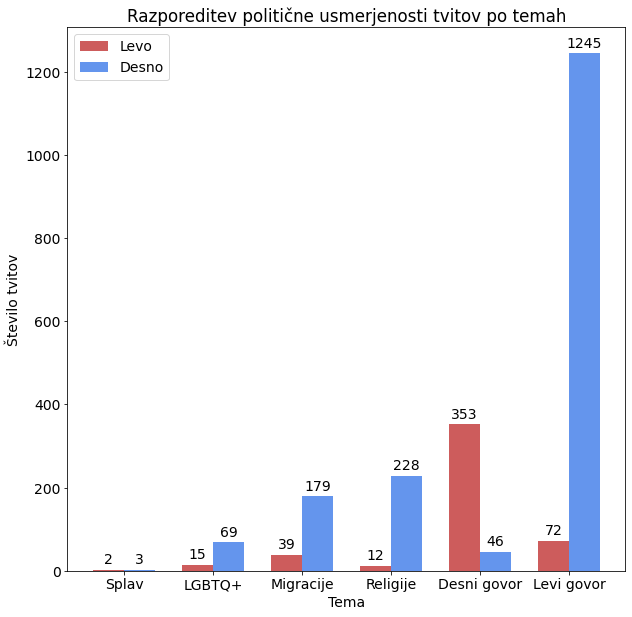

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

nms = ['Splav', 'LGBTQ+', 'Migracije', 'Religije', 'Desni govor', 'Levi govor']
#clrs = ['green', 'indigo', 'hotpink', 'orange', 'royalblue', 'firebrick']

x = np.arange(len(nms))
width = 0.35  # the width of the bars


rc1 = ax.bar(x - width/2, [l for l,n,d in viz_data], width, color='indianred', label="Levo")
rc2 = ax.bar(x + width/2, [d for l,n,d in viz_data], width, color='cornflowerblue', label="Desno")
ax.set_xlabel('Tema')
ax.set_ylabel('Število tvitov')
ax.set_xticks(x, nms)
ax.set_title('Razporeditev politične usmerjenosti tvitov po temah')

ax.legend()

ax.bar_label(rc1, padding=3)
ax.bar_label(rc2, padding=3)

fig.show()

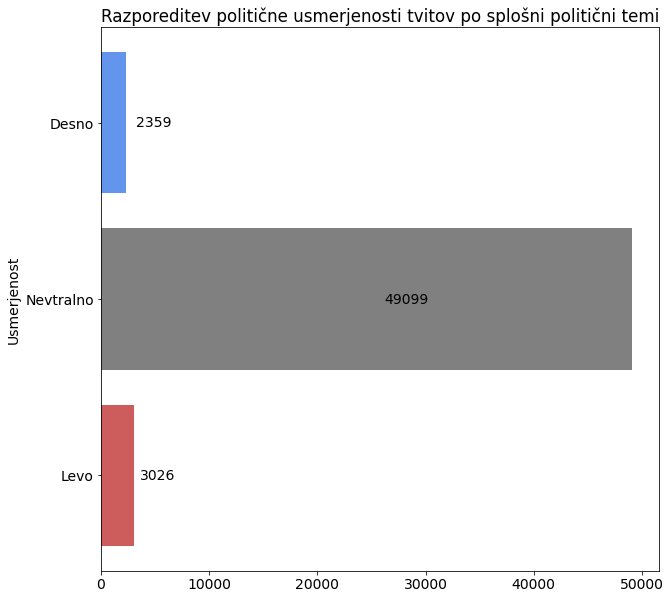

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

x = np.arange(len(viz_politika))
width = 0.35  # the width of the bars

bars = ax.barh(x, viz_politika, color=['indianred', 'grey', 'cornflowerblue'])

ax.set_ylabel('Število tvitov')
ax.set_ylabel('Usmerjenost')
ax.set_yticks(x, ['Levo', 'Nevtralno', 'Desno'])
ax.set_title('Razporeditev politične usmerjenosti tvitov po splošni politični temi')


ax.bar_label(bars, label_type='center', padding=40)
fig.show()

In [ ]:
names = ['splav', 'lgbtq','begunci','religija', 'desno', 'levo', 'null']

viz_data = {}

for i, n in enumerate(names):
  raw_t_data = load_data(f'{root_dir}/process/tweets_{n}.json')

  for t in raw_t_data:
    if t['prediction']['party_mentioned'] is not None:
      if t['prediction']['party_mentioned'] in viz_data:
        viz_data[t['prediction']['party_mentioned']].append(t)
      else:
        viz_data[t['prediction']['party_mentioned']] = []
        viz_data[t['prediction']['party_mentioned']].append(t)

  
viz_data['PS'] = [ t for t in viz_data['PS'] if t['mentions'] in ['piratskastranka'] ]
viz_data['GS'] = [ t for t in viz_data['GS'] if t['mentions'] in ['Gibanje_Svoboda'] ]

stranka_data = []

for v in viz_data:
  tviti = viz_data[v]
  if len(tviti) == 0:
    continue
  poz = 0
  neg = 0
  nevt = 0
  for t in tviti:
    if t['prediction']['sentiment'] == 'positive':
      poz = poz+1
    elif t['prediction']['sentiment'] == 'negative':
      neg = neg+1
    elif t['prediction']['sentiment'] == 'neutral':
      nevt = nevt+1
  
  stranka_data.append((poz, nevt, neg))

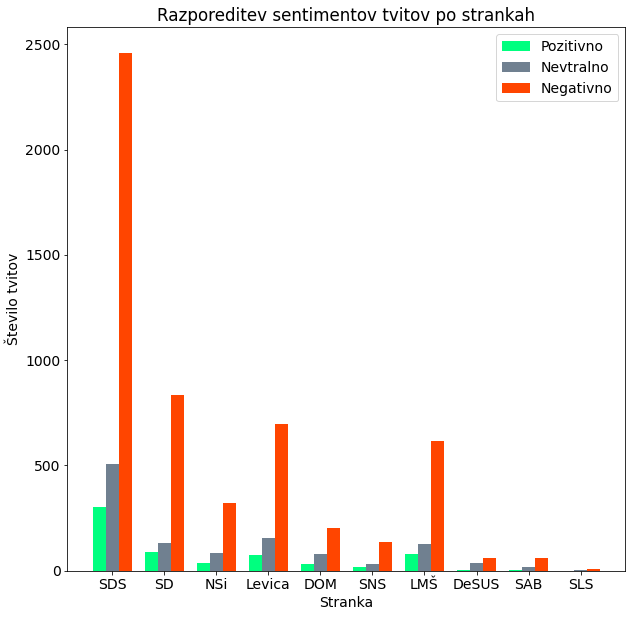

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

nms = [ z for z in viz_data if len(viz_data[z]) > 0]

#clrs = ['green', 'indigo', 'hotpink', 'orange', 'royalblue', 'firebrick']

x = np.arange(len(nms))
width = 0.25  # the width of the bars


rc1 = ax.bar(x - width, [p for p,n,neg in stranka_data], width, color='springgreen', label="Pozitivno")
rc2 = ax.bar(x, [n for p,n,neg in stranka_data], width, color='slategrey', label="Nevtralno")
rc3 = ax.bar(x + width, [neg for p,n,neg in stranka_data], width, color='orangered', label="Negativno")
ax.set_xlabel('Stranka')
ax.set_ylabel('Število tvitov')
ax.set_xticks(x, nms)
ax.set_title('Razporeditev sentimentov tvitov po strankah')

ax.legend()

#ax.bar_label(rc1, padding=3)
#ax.bar_label(rc2, padding=3)
#ax.bar_label(rc3, padding=3)

fig.show()

In [ ]:
punct = str.maketrans('', '', string.punctuation)

def clean_str(test_str):
  return " ".join(test_str.translate(punct).split())

def make_wordcloud(wrds):
  fig, ax = plt.subplots(figsize = (7, 7), facecolor = None)
  wc = WordCloud(width = 800, height = 800, max_font_size=140, min_font_size = 10, max_words=100, 
                 stopwords = ['2x', '3x', 'stopnja', '4x', '5x', '6x', 'omeniti', 'obsedenost'],
                 background_color="white").generate(wrds)
  ax.imshow(wc)
  ax.axis("off")
  fig.tight_layout(pad = 0)
  fig.show()

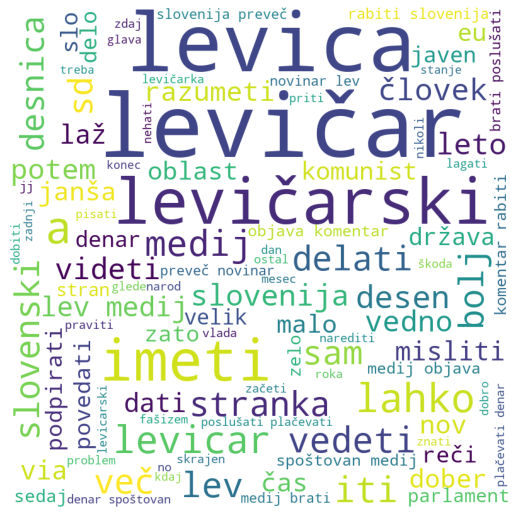

In [ ]:
# Wordclouds for themes
names = ['splav', 'lgbtq', 'begunci', 'religija', 'desno', 'levo', 'null']

viz_data = []

#fig, ax = plt.subplots(figsize=(10,10), facecolor=None)

for i, n in enumerate(names):
  raw_t_data = load_data(f'{root_dir}/process/tweets_{n}.json')

  words = ""
  for t in raw_t_data:
    words = words + " " + clean_str(t['lemma_text'])

  make_wordcloud(words)
  break
  

## Evalvacija modela tematik

In [ ]:
# Configurations for automated bias pipeline

VERBOSE = True
SAVING = False
DEBUG = False

## Tweetiment configuration
topic_bias_path = root_dir + '/configs/topic-bias.json'
party_bias_path = root_dir + '/configs/party-bias.json'

tweetiment_config = {
    'topic_bias': load_data(topic_bias_path),
    'party_bias': load_data(party_bias_path)
}

## Bertopic second layer configuration
tweetiment_bertopic_SL_config = {
    'bertopic_conf': {
        "top_n_words": 10,
        "min_topic_size": 20,
        #"nr_topics": 8
    },
    'umap_conf': {
        "n_neighbors": 20,
        "n_components": 10,
        "metric": 'cosine'
    },
    'hdbscan_conf': {
        "min_cluster_size": 15,
        "metric": 'euclidean',
        "prediction_data": True
    },
    'shuffle_arrays': True,
    'random_state': 77
}

## Topic information
tweetiment_topics_info = {
    'begunci': {
        'search_term': ["begunec", "migrant", "migrantski"],
        'keywords': [],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.5
    },
    'lgbtq': {
        'search_term': ["lgbtq", "lgbt", "istospolno"],
        'keywords': [],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.5
    },
    'religija': {
        'search_term': ["islam", "musliman", "vera"],
        'keywords': ["religija", "dzihadist"],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.5
    },
    'splav': {
        'search_term': ["splav"],
        'keywords': ["kontracepcija"],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.5
    },
    'desno': {
        'search_term': ["desnica", "desno", "jj", "sds"],
        'keywords': ["jansa", "desnicar", "janša"],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.5
    },
    'levo': {
        'search_term': ["levica", "levicar", "lev"],
        'keywords': ["levicarski", "levičar", "mesec"],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.5
    },
    'politika': {
        'search_term': ["politika", "politicen", "vlada"],
        'keywords': [],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.5
    }
}

pbm_config = {}
pbm_config['bertopic_SL_config'] = tweetiment_bertopic_SL_config
pbm_config['preprocess_config'] = None
pbm_config['tweetiment_config'] = tweetiment_config
pbm_config['topic_info'] = tweetiment_topics_info
pbm_config['verbose'] = VERBOSE
pbm_config['debug'] = DEBUG

In [ ]:
# Loading models

# Embedding model
topic_model = AutoModelForMaskedLM.from_pretrained("EMBEDDIA/sloberta")

sent_model = {}
sent_model['tokenizer'] = AutoTokenizer.from_pretrained("EMBEDDIA/sloberta-tweetsentiment")
sent_model['model'] = AutoModelForSequenceClassification.from_pretrained("EMBEDDIA/sloberta-tweetsentiment")

In [ ]:
# Collect and split test data

topic_names = ['splav', 'begunci', 'lgbtq', 'religija', 'levo', 'desno', 'politika']

data = []

X_train = []
y_train = []

X_test = []
y_test = []

for t in topic_names:
  raw_result_data = load_data(f'{root_dir}/labelled_topics/topic_{t}.json')

  docs = []
  labels = []

  for d in raw_result_data:
    if not 'id' in d:
      continue
    labels.append(topic_names.index(d['topic']))
    d['topic'] = None
    docs.append(d)
  

  iX_train, iX_test, iy_train, iy_test = train_test_split(docs, labels, test_size=0.33, random_state=442)
  
  X_train.extend(iX_train)
  y_train.extend(iy_train)
  X_test.extend(iX_test)
  y_test.extend(iy_test)


# Shuffle for good measure

X_train, y_train = shuffle(X_train, y_train, random_state=276)

## Evalvacija modela za modeliranja tem

In [ ]:
pt_model = PoliticBiasModel("PoliticBias",
                            root_dir,
                            None,
                            topic_model,
                            sent_model,
                            pbm_config)

# Manually train the topic model
pt_model.bertopic_SL.load_topic_data([d['lemma_text'] for d in X_train], y_train)

# Train model
pt_model.bertopic_SL.train_model(only_fit=True)

# Load data
pt_model.bertopic_SL.load_tweet_data(X_test)

# Predict on test data
pt_model.bertopic_SL.predict()

# Label
lbl_t = label_politic_tweets(pt_model.bertopic_SL, tweetiment_topics_info, "")

-- Collected batch topic distribution summary:


In [ ]:
y_pred = []
for d in lbl_t:
  if d['topic'] is not None:
    y_pred.append(topic_names.index(d['topic']))
  else:
    y_pred.append(-1)

print(y_pred)
print(y_test)

In [ ]:
score = accuracy_score(y_test, y_pred)

print(score)

In [ ]:
elim = [ i for i, d in enumerate(y_pred) if d == -1 ]

y_pred = list(filter(lambda d: d != -1, y_pred))

for j in elim:
  y_test[j] = -1

y_test = list(filter(lambda d: d != -1, y_test))

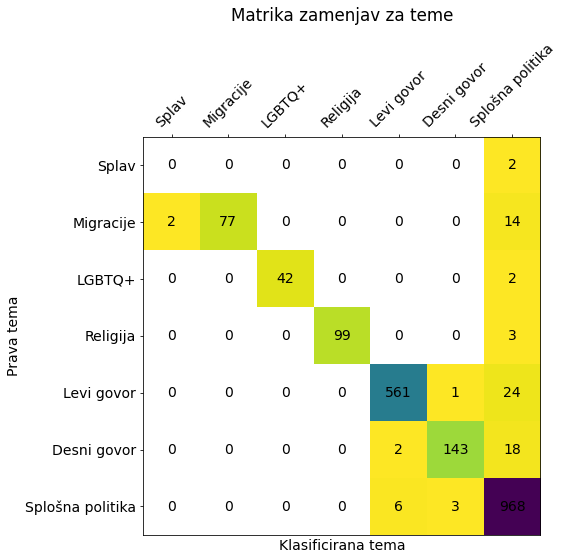

In [ ]:
# Heat map for topics

nms = ['Splav', 'Migracije', 'LGBTQ+', 'Religija', 'Levi govor', 'Desni govor', 'Splošna politika']

cf_m = confusion_matrix(y_test, y_pred)

data_masked = np.ma.masked_where(cf_m == 0, cf_m)

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(data_masked, cmap='viridis_r', interpolation = 'none', vmin = 0, aspect='auto')


plt.xticks(np.arange(len(nms)), labels=nms, rotation=45)
plt.yticks(np.arange(len(nms)), labels=nms)
ax.xaxis.tick_top()

#plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(nms)):
    for j in range(len(nms)):
        text = ax.text(j, i, cf_m[i, j],
                       ha="center", va="center", color="black")

ax.set_xlabel('Klasificirana tema')
ax.set_ylabel('Prava tema')
ax.set_title('Matrika zamenjav za teme', pad=20)
fig.tight_layout()
fig.show()

## Evalvacija modela za klasifikacije usmerjenosti

In [ ]:
# Configurations for automated bias pipeline

VERBOSE = True
SAVING = False
DEBUG = False

## Tweetiment configuration
topic_bias_path = root_dir + '/configs/topic-bias.json'
party_bias_path = root_dir + '/configs/party-bias.json'

tweetiment_config = {
    'topic_bias': load_data(topic_bias_path),
    'party_bias': load_data(party_bias_path)
}

## Bertopic second layer configuration
tweetiment_bertopic_SL_config = {
    'bertopic_conf': {
        "top_n_words": 10,
        "min_topic_size": 20,
        #"nr_topics": 8
    },
    'umap_conf': {
        "n_neighbors": 20,
        "n_components": 10,
        "metric": 'cosine'
    },
    'hdbscan_conf': {
        "min_cluster_size": 15,
        "metric": 'euclidean',
        "prediction_data": True
    },
    'shuffle_arrays': True,
    'random_state': 77
}

## Topic information
tweetiment_topics_info = {
    'begunci': {
        'search_term': ["begunec", "migrant", "migrantski"],
        'keywords': [],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.5
    },
    'lgbtq': {
        'search_term': ["lgbtq", "lgbt", "istospolno"],
        'keywords': [],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.5
    },
    'religija': {
        'search_term': ["islam", "musliman", "vera"],
        'keywords': ["religija", "dzihadist"],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.5
    },
    'splav': {
        'search_term': ["splav"],
        'keywords': ["kontracepcija"],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.5
    },
    'desno': {
        'search_term': ["desnica", "desno", "jj", "sds"],
        'keywords': ["jansa", "desnicar", "janša"],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.5
    },
    'levo': {
        'search_term': ["levica", "levicar", "lev"],
        'keywords': ["levicarski", "levičar", "mesec"],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.5
    },
    'politika': {
        'search_term': ["politika", "politicen", "vlada"],
        'keywords': [],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.5
    }
}

pbm_config = {}
pbm_config['bertopic_SL_config'] = tweetiment_bertopic_SL_config
pbm_config['preprocess_config'] = None
pbm_config['tweetiment_config'] = tweetiment_config
pbm_config['topic_info'] = tweetiment_topics_info
pbm_config['verbose'] = VERBOSE
pbm_config['debug'] = DEBUG

In [ ]:
# Loading models

# Embedding model
topic_model = AutoModelForMaskedLM.from_pretrained("EMBEDDIA/sloberta")

sent_model = {}
sent_model['tokenizer'] = AutoTokenizer.from_pretrained("EMBEDDIA/sloberta-tweetsentiment")
sent_model['model'] = AutoModelForSequenceClassification.from_pretrained("EMBEDDIA/sloberta-tweetsentiment")

In [ ]:
# Collect and split test data

labels = ['levo', 'desno', 'nevtralno']

topic_names = ['begunci', 'splav', 'lgbtq', 'religija', 'desno', 'levo']

data = []

X_train = []
y_train = []

X_test = []
y_test = []

for t in topic_names:
  raw_result_data = load_data(f'{root_dir}/process/tweets_{t}.json')

  docs = raw_result_data
  lbls = [ labels.index(t['prediction']['label']) for t in raw_result_data]

  iX_train, iX_test, iy_train, iy_test = train_test_split(docs, lbls, test_size=0.33, random_state=1)
  
  X_train.extend(iX_train)
  y_train.extend(iy_train)
  X_test.extend(iX_test)
  y_test.extend(iy_test)


# Shuffle for good measure

X_train, y_train = shuffle(X_train, y_train, random_state=2)

In [ ]:
pt_model = PoliticBiasModel("PoliticBias",
                            root_dir,
                            None,
                            topic_model,
                            sent_model,
                            pbm_config)

# Manually train the topic model
pt_model.bertopic_SL.load_topic_data([d['lemma_text'] for d in X_train], y_train)

# Train model
pt_model.bertopic_SL.train_model(only_fit=True)

# Load data
pt_model.bertopic_SL.load_tweet_data(X_test)

# Predict on test data
pt_model.bertopic_SL.predict()

# Label
lbl_t = label_politic_tweets(pt_model.bertopic_SL, tweetiment_topics_info, "")

# Predict labels
y_pred = []

for t in lbl_t:
  y_pred.append(pt_model.tweetiment.calculate_biases(t)['label'])

y_predictions = [ labels.index(d) for d in y_pred]

In [ ]:
score = accuracy_score(y_test, y_predictions)

print(score)

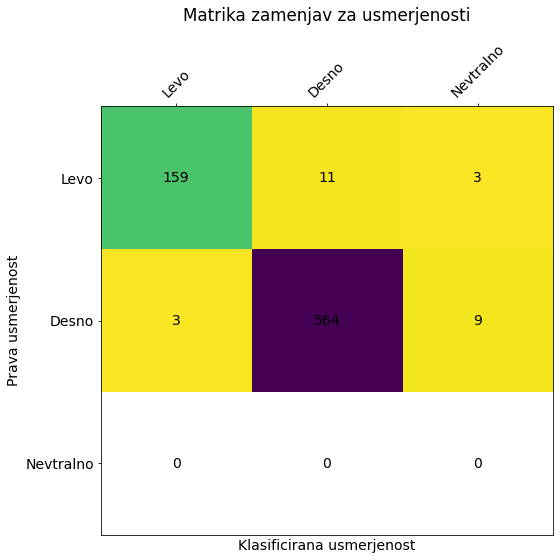

In [ ]:
# Heat map for topics

nms = ['Levo', 'Desno', 'Nevtralno']

cf_m = confusion_matrix(y_test, y_predictions)

data_masked = np.ma.masked_where(cf_m == 0, cf_m)

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(data_masked, cmap='viridis_r', interpolation = 'none', vmin = 0, aspect='auto')

plt.xticks(np.arange(len(nms)), labels=nms, rotation=45)
plt.yticks(np.arange(len(nms)), labels=nms)
ax.xaxis.tick_top()

#plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(nms)):
    for j in range(len(nms)):
        text = ax.text(j, i, cf_m[i, j],
                       ha="center", va="center", color="black")

ax.set_xlabel('Klasificirana usmerjenost')
ax.set_ylabel('Prava usmerjenost')
ax.set_title('Matrika zamenjav za usmerjenosti', pad=20)
fig.tight_layout()
fig.show()

## Evalvacija modela na novi testni množici

In [ ]:
# Configurations for automated bias pipeline

VERBOSE = True
SAVING = False
DEBUG = False

## Tweetiment configuration
topic_bias_path = root_dir + '/configs/topic-bias.json'
party_bias_path = root_dir + '/configs/party-bias.json'

tweetiment_config = {
    'topic_bias': load_data(topic_bias_path),
    'party_bias': load_data(party_bias_path)
}

## Bertopic second layer configuration
tweetiment_bertopic_SL_config = {
    'bertopic_conf': {
        "top_n_words": 10,
        "min_topic_size": 20,
        "nr_topics": 8
    },
    'umap_conf': {
        "n_neighbors": 20,
        "n_components": 10,
        "metric": 'cosine'
    },
    'hdbscan_conf': {
        "min_cluster_size": 15,
        "metric": 'euclidean',
        "prediction_data": True
    },
    'shuffle_arrays': True,
    'random_state': 77
}

## Topic information
tweetiment_topics_info = {
    'begunci': {
        'search_term': ["begunec", "migrant", "migrantski"],
        'keywords': [],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.3
    },
    'lgbtq': {
        'search_term': ["lgbtq", "lgbt", "istospolno"],
        'keywords': [],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.3
    },
    'religija': {
        'search_term': ["islam", "musliman", "vera"],
        'keywords': ["religija", "dzihadist"],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.3
    },
    'splav': {
        'search_term': ["splav"],
        'keywords': ["kontracepcija"],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.3
    },
    'desno': {
        'search_term': ["desnica", "desno", "jj", "sds"],
        'keywords': ["jansa", "desnicar", "janša"],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.3
    },
    'levo': {
        'search_term': ["levica", "levicar", "lev"],
        'keywords': ["levicarski", "levičar", "mesec"],
        'strict': False,
        'sim_threshold': 0.2,
        'tweet_prob': 0.3
    }
}

# Preprocessing configuration
preprocess_config = {
    'min_words': 1,
    'verbose': VERBOSE,
    'debug': DEBUG,
    'tweet_upos': ['PUNCT', 'NUM', 'SYM', 'CCONJ', 'INTJ'],
    'tweet_stop_words': ['http', 'https', 'rt', 'oz']
}

# Classla configuration
classla_conf = {
  #'processors': 'tokenize, lemma',
  'lang': 'sl',
  'pos_lemma_pretag' : True,
  'use_gpu': True
}

pbm_config = {}
pbm_config['bertopic_SL_config'] = tweetiment_bertopic_SL_config
pbm_config['preprocess_config'] = preprocess_config
pbm_config['tweetiment_config'] = tweetiment_config
pbm_config['topic_info'] = tweetiment_topics_info
pbm_config['verbose'] = VERBOSE
pbm_config['debug'] = DEBUG

In [ ]:
# Classla preprocessor
classla_pipeline = classla.Pipeline(**classla_conf)

# Tweet preprocessor
tpre.set_options(tpre.OPT.URL, tpre.OPT.MENTION, tpre.OPT.HASHTAG)

# Embedding model
topic_model = AutoModelForMaskedLM.from_pretrained("EMBEDDIA/sloberta")

sent_model = {}
sent_model['tokenizer'] = AutoTokenizer.from_pretrained("EMBEDDIA/sloberta-tweetsentiment")
sent_model['model'] = AutoModelForSequenceClassification.from_pretrained("EMBEDDIA/sloberta-tweetsentiment")

In [ ]:
# MAIN CODE for testing new data

# Prepare Politic bias model
pt_model = PoliticBiasModel("PoliticBias-Testing",
                            root_dir,
                            classla_pipeline,
                            topic_model,
                            sent_model,
                            pbm_config)

# Train the models
pt_model.train_models()

In [ ]:
pt_model.optimize_models()

In [ ]:
pt_model.bertopic_SL.visualize()

In [ ]:
pt_model.bertopic_SL.visualize('barchart')

In [ ]:
# Collect topic data
topic_names = ['splav', 'begunci', 'lgbtq', 'religija', 'levo', 'desno']

label_names = ['levo', 'desno', 'nevtralno']


X_test = []
y_test_topics = []
y_test_labels = []

i = 0

for t in topic_names:
  raw_result_data = load_data(f'{root_dir}/test/topic_{t}.json')
  for sample in raw_result_data:
    # Convert to tweet format
    X_test.append({
        'id': i,
        'full_text': sample['raw_text'],
        'hashtags': [],
        'mentions': [],
        'created_at': None,
        'user': {
            'name': None,
            'screen_name': None,
            'description': ''
        }
    })
    y_test_topics.append(sample['topic'])
    y_test_labels.append(sample['label'])
    i = i+1


X_test, y_test_topics, y_test_labels = shuffle(X_test, y_test_topics, y_test_labels, random_state=666)

print(X_test)
print(y_test_topics)
print(y_test_labels)

In [ ]:
# Predict labels

y_tweets, y_pred_labels = pt_model.bias_pipeline(X_test, do_preprocess=True, topn=2, n_sim_subtopics=2)

n_t = len(y_pred_labels)

In [ ]:
elim = [  i for i, l in enumerate(y_pred_labels) if l is None or l['topic_mentioned'] is None ]

for e in elim:
  y_test_topics[e] = None
  y_test_labels[e] = None

y_test_topics = list(filter(lambda x: x is not None, y_test_topics))
y_test_topics = list(map(lambda x: topic_names.index(x), y_test_topics))

y_test_labels = list(filter(lambda x: x is not None, y_test_labels))
y_test_labels = list(map(lambda x: label_names.index(x), y_test_labels))

y_pred_labels_f = list(filter(lambda x: x is not None and x['topic_mentioned'] is not None, y_pred_labels))

#y_pred_labels = [ l['topic_mentioned'] for l in y_pred_labels ]

In [ ]:
score_topics = accuracy_score([topic_names.index(p['topic_mentioned']) for p in y_pred_labels_f], y_test_topics)
score_labels = accuracy_score([label_names.index(p['label']) for p in y_pred_labels_f], y_test_labels)

print(f'Score topics: {score_topics}')
print(f'Score labels: {score_labels}')
print(f'Number of tweets labelled: {len(y_pred_labels_f)}/{n_t}')